# A Colour Illusion
This is designed to show you how your eye interpolates colour and is far more sensitive to intensity (grayscale) than colour.

For this lab, you will need an image of your choosing.

First, we'll import some useful packages: skimage, matplotlib and numpy. We'll also inline matplotlib. Note that you might need:
`!pip install <package name>`
if the packages are not recognised on your system.

In [1]:
import cv2 as cv2
import skimage as skimage
from skimage import io, data, color, filters
#from skimage.color import rgb2ycbcr
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

Now, this is where you'll need a picture. Find a suitable image for your purposes (my image was called tiger.bmp and I had it in the same folder as this Jupyter notebook). Load your image with OpenCV and get its dimensions. 

In [3]:
imageName = "tiger.bmp"
#imageName = "aphaniz_503.tiff"
img = skimage.io.imread(imageName)
#img = cv2.imread(imageName)
height, width = img.shape[:2]
print("The image is {} by {}".format(width, height))

The image is 320 by 240


And now display it using matplotlib. I've put the code for showing an image and removing the matplotlib axes data into my own function, but there are other ways to do this.

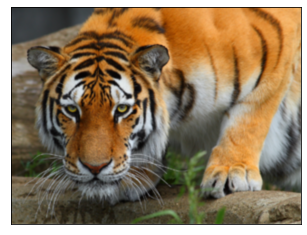

In [4]:
def showImage(image):
    plt.imshow(image, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
showImage(img)

In [ ]:
# An alternative way of getting the pixles of an image. You don't need to run this.
from PIL import Image
im = Image.open(imageName)
pixels = list(im.getdata())
pixels = np.asarray(pixels, 'u1')
print (pixels.shape)
pixels.reshape

And viewing the colour channels independently:

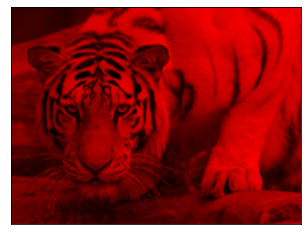

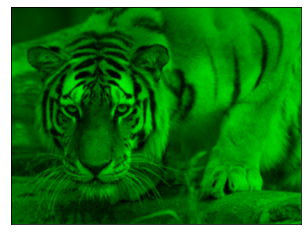

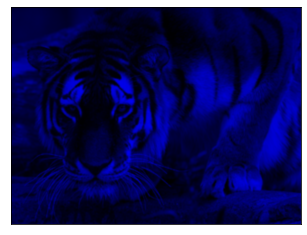

In [4]:
imgR = img.copy()
imgR[:,:,1] = 0
imgR[:,:,2] = 0
showImage(imgR)

imgG = img.copy()
imgG[:,:,0] = 0
imgG[:,:,2] = 0
showImage(imgG)

imgB = img.copy()
imgB[:,:,0] = 0
imgB[:,:,1] = 0
showImage(imgB)

And now, we'll convert to YUV colour space. Other colour spaces are available, but video coding uses a colour space called YUV420.  Here are the functions necessary for conversion. Some libraries (e.g. opencv and sklearn) provide colour space conversion functions. These will be investigated later in this lab.

In [5]:
def thresholdAndRound(y):
    maxn = 255
    minn = 0
    y[y > maxn] = maxn
    y[y < minn] = minn
    y = np.around(y,0)
    return y

def convertToBytes(y):
    y = np.asarray(y, 'u1')
    return y

# planar YUV 4:4:4 to rgb
def planarYUV_2_planarRGB(data, width, height):
    #print("in planarYUV_2_planarRGB")
    maxn = 255
    minn = 0
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]    
    
    r = y + 1.403 * (v-delta)
    g = y - (0.714 * (v-delta)) - (0.344 * (u-delta))
    b = y + 1.773 * (u-delta)   
    
    r = thresholdAndRound(r)
    r = convertToBytes(r)
    g = thresholdAndRound(g)
    g = convertToBytes(g)
    b = thresholdAndRound(b)
    b = convertToBytes(b)
    
    rgb = np.concatenate((r,g,b), axis = 0)
    rgb = rgb.reshape((width*height*3), )
    return rgb

def quantiseUV(data, width, height):
    numLevels = 16
    q = 256/numLevels
    x = np.linspace(0, 10, 1000)
    
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]
    
    u = q * np.round(u/q)
    v = q * np.round(v/q)

    yuv = np.concatenate((y,u,v), axis = 0)
    return yuv

#Note that this function takes as input a planar RGB image
# It returns planar YUV4:4:4 (it's not common but it can be downsampled to 4:2:0)
def planarRGB_2_planarYUV(data, width, height):
    #print("in planarRGB_2_planarYUV")
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    r = np.array(picture[0])
    g = np.array(picture[1])
    b = np.array(picture[2])
    
    y = np.array(0.299*r + 0.587*g + 0.114*b)
    y = thresholdAndRound(y)
    u = ((b-y)*0.564) + delta
    v = ((r-y)*0.713) + delta
    
    y = thresholdAndRound(y)
    u = thresholdAndRound(u)
    v = thresholdAndRound(v)
    y = convertToBytes(y)
    u = convertToBytes(u)
    v = convertToBytes(v)
    
    yuv = np.concatenate((y,u,v), axis = 0)
    yuv = yuv.reshape((width*height*3), )
    
    return yuv

def RGB2YUV(img):
    width = img.shape[1]
    height = img.shape[0]
    img_ = np.transpose(img,(2,1,0))
    yuv = planarRGB_2_planarYUV(img_, width, height)
    yuv = yuv.reshape((3, width, height))
    #yuv = 255-yuv
    return yuv

def YUV2RGB(yuv):
    width = yuv.shape[1]
    height = yuv.shape[2]
    rgb = planarYUV_2_planarRGB(yuv, width, height)
    rgb = rgb.reshape((3, width, height))
    rgb = np.transpose(rgb, (2,1,0))
    return rgb


This is the Y channel

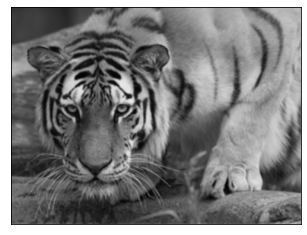

In [6]:
img_yuv = RGB2YUV(img)
imgY = img_yuv.copy()
#imgY[0, :, :] = 0
imgY[1, :, :] = 128
imgY[2, :, :] = 128

imgY_rgb = YUV2RGB(imgY)
showImage(imgY_rgb)

Then the U channel:

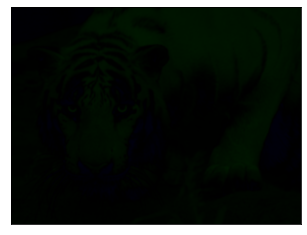

In [7]:
imgU = img_yuv.copy()
imgU[0, :, :] = 0
#imgU[1, :, :] = 128
imgU[2, :, :] = 128

imgU_rgb = YUV2RGB(imgU)
showImage(imgU_rgb)

Then the V channel:

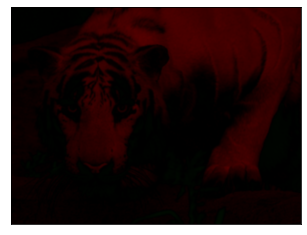

In [8]:
imgV = img_yuv.copy()
imgV[0, :, :] = 0
imgV[1, :, :] = 128
#imgV[2, :, :] = 128

imgV_rgb = YUV2RGB(imgV)
showImage(imgV_rgb)

As you can see, not much actual colour there. It's mostly the intensity that contributes to the look of the image. At this point, you can try different images to see what is U and what is V. 
Let's look at it more closely by setting all the intensity values to white.

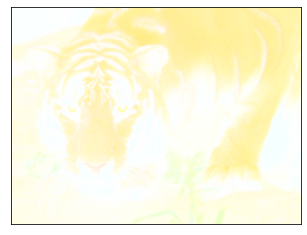

In [9]:
img_colour = img_yuv.copy()
img_colour[0, :, :] = 255

img_colour_rgb = YUV2RGB(img_colour)
showImage(img_colour_rgb)

In the above and below cells, you might try playing with the value that you set the Y-channel to. What does a Y-value of 128 give you? What does a Y-value of 0 give you?

Can you alter the code to find out what happens if you set the U- and V- channels to constant values?

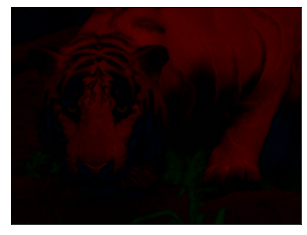

In [10]:
img_colour = img_yuv.copy()
img_colour[0, :, :] = 0

img_colour_rgb = YUV2RGB(img_colour)
showImage(img_colour_rgb)

We're going to reduce the colour information in the image. We're going to do it so that only some pixels in the image are coloured but all pixels in the image contain valid Y-channel values. There are other ways to do this: you could give all the pixels in the image Y- U- and V- values, but average the U- and V- values over 8x8 squares of pixels, or 16x16 squares of pixels.

For our method, we are going to create a grid of lines. First, it's just a vertical/horizontal grid which is double the dimensions of what we need. We're going to apply an affine transform and then crop out the centre part of the image so that we get a nice, even grid all over the image.

In [11]:
gridSpacing = 16
gridAngle = 60
grid = np.zeros((width*2, height*2))

for i in range(0, width*2):
    for j in range(0, height*2):
        if (i % gridSpacing) == 0:
            grid[i, j] = 1
        if (j % gridSpacing) == 0:
            grid[i, j] = 1
                
# Rotate the grid:
M = cv2.getRotationMatrix2D((height,width),gridAngle,1)
grid = cv2.warpAffine(grid,M,(height*2, width*2))
start_w = width//2
start_h = height//2
end_w = start_w + width
end_h = start_h + height
grid = grid[start_w:end_w, start_h:end_h]
grid[grid != 0] = 1

print(grid.shape)



(320, 240)


### Extra task
Display the grid in the same way you displayed the images. It is currently a single channel with values of 0 and 1 in it. You need to convert it to be three channels (R,G,B) in order to use our showImage function. Remember that an RGB pixel value of (255, 255, 255) gives the whitest white pixel. An RGB pixel value of (0,0,0) gives the blackest black pixel.
        

### Apply the grid to our image
Note that you have to set any "0" values to 128 in the colour channels because that gives greyscale. But if you like, you can change these values and discover what colour you get.

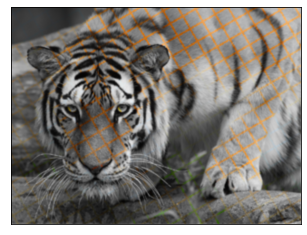

True

In [12]:
myY = imgY[0, :, :]
myU = np.multiply(grid, imgU[1, :, :])
myU[myU == 0] = 128
myV = np.multiply(grid, imgV[2, :, :])
myV[myV == 0] = 128

img_gridded = img_yuv.copy()
img_gridded[0, :, :] = myY
img_gridded[1, :, :] = myU
img_gridded[2, :, :] = myV

img_gridded_rgb = YUV2RGB(img_gridded)
showImage(img_gridded_rgb)
img_gridded_bgr = cv2.cvtColor(img_gridded_rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite("tiger.png", img_gridded_bgr)

### Observe the resulting image above. 
Can you "see" the colour? Are the grid lines as obvious as you thought they were going to be?

### Showing the grayscale and colour channels independently
The next cell shows you how to display the grayscale and colour independently and save the image to file.
Notice that before we save the image, we run another openCV convert colour function. Can you find out why we call this conversion? What is it for and what does it do?

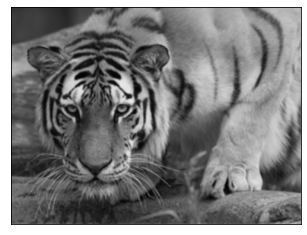

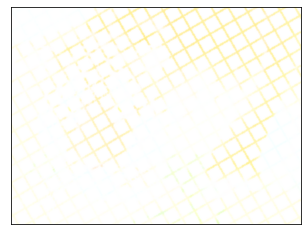

True

In [13]:
imgY = img_yuv.copy()
imgY[0, :, :] = myY
imgY[1, :, :] = 128
imgY[2, :, :] = 128
imgY_rgb = YUV2RGB(imgY)
showImage(imgY_rgb)
imgY_bgr = cv2.cvtColor(imgY_rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite("ytiger.png", imgY_bgr)

imgUV = img_yuv.copy()
imgUV[0, :, :] = 255
imgUV[1, :, :] = myU
imgUV[2, :, :] = myV
imgUV_rgb = YUV2RGB(imgUV)
showImage(imgUV_rgb)
imgUV_bgr = cv2.cvtColor(imgUV_rgb,cv2.COLOR_RGB2BGR)
cv2.imwrite("uvtiger.png", imgUV_bgr)

And now, to show just how little colour is in that image, this is the complete image with the grid applied:

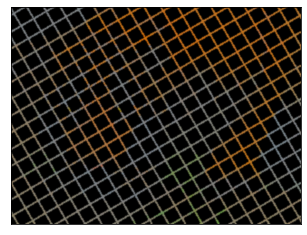

In [14]:
myY = imgY[0, :, :]
myY = np.multiply(grid, imgY[1, :, :])
myU = np.multiply(grid, imgU[1, :, :])
myU[myU == 0] = 128
myV = np.multiply(grid, imgV[2, :, :])
myV[myV == 0] = 128

img_gridded = img_yuv.copy()
img_gridded[0, :, :] = myY
img_gridded[1, :, :] = myU
img_gridded[2, :, :] = myV

img_gridded_rgb = YUV2RGB(img_gridded)
showImage(img_gridded_rgb)

### Now it's over to you

There are more colour spaces than YUV. Have a look at the `cvtColor` function in openCV: https://docs.opencv.org/4.x/d8/d01/group__imgproc__color__conversions.html to see which colour spaces are available and now you know how to display each channel independently, you will be able to get familiar with the different colour spaces and understand what they visually represent.